<a href="https://colab.research.google.com/github/FeLorentzo/Aircraft_Performance/blob/main/Example_compute_routine_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

\

**Rotina completa de cálculo de alcance de uma aeronave**

\


Data: 10 de julho de 2023

# Introdução e objetivos

No contexto de projeto conceitual de uma aeronave, objetiva-se calcular a performance em 3 estágios:
1. Voo ascendente
2. Cruzeiro
3. Aproximação

Usando como dados de entrada estimativas das características macro de geometria de asa, arrasto viscoso, pesos de operação, empuxo e consumo do motor. Os dados então contidos a seguir:


*   Área de asa ($S_w$) = 92.5 m²
*   Alongamento da asa ($AR_w$) = 8.9
*   Fator de Oswald ($e$) = 0.85
*   Arrasto viscoso ($CD_0$) = 0.025
*   Empuxo ao nível do mar ($Thrust_0$) = 92300 N
*   $TSFC$ = 0.85 N/h/N (após verificação da rotina, concluiu-se que, caso o TSFC estivesse em kg/N/h, a aeronave consumiria cerca de 60% do combustível para subir de 0 a 20000 ft, completamente inconsistente)
*   $MTOW$ = 450300 N
*   Peso de combustível ($W_f$) = 130000 N
*   $BOW$  = 320300 N

Além disso, as condições de operação do aeroporto de partida e de chagada estão dadas abaixo:

* Altitude do aeroporto de partida e de chagada = nível do mar
* Condições ISA para destino = ISA+15
* Altitude máxima de cruzeiro = FL 410

Acrescenta-se a estes dados as condições relacionadas ao aeroporto alternaivo para pouso

* Distância: 200 milhas náuticas = 370400 m
* Altitude de cruzeiro: FL200
* Condições ISA: ISA+20
* Condições de espera: máximo *endurance* a 10000 ft por 30 minutos
* Altitude do aeroporto: 2000 ft

A alternativa atua como uma "redundância para pouso": caso o aeroporto de destino esteja indisponível por questões de infraestrutura, tráfego aéreo ou condições metereológicas adversas, a aeronave deve ter combustível o suficiente para abortar o pouso no aeroporto de destino, ascender até a altitude operacional e pousar na alternativa.

Para cálculos de alcance em cruzeiro, considerar regime *long range*. Pede-se para adotar Mach constante, mas tendo em vista manter o regime long range, este será variável.

Leva-se em consideração, também, a necessidade de aplicar *step climb* caso a razão de subida torne-se menor que 500 ft/min = 2.54 m/s; ele deve ser aplicado no nível de voo adequado, a cada 2000 ft, conforme órgão certificador.

# Importar bibliotecas


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Conversão de unidades

In [ ]:
def ft2m(ft):
    return 0.3048 * ft


def ftmin2ms(ftmin):
    return 0.00508 * ftmin


def nm2m(nm):
    return 1852 * nm


# Modelo de atmosfera real

Funções para cálculo de temperatura, pressão, densidade e velocidade do som pelo modelo ISA, e correção para variações na temperatura na obtenção da atmosfera real.

In [ ]:
def atmosisa(h):
    '''
    Return [T, P, rho, a]

    h = meters

    T = kelvin
    P = Pa
    rho = Kg/m³
    a = m/s
    '''
    T0 = 288.15
    P0 = 101325
    a0 = 340.3
    rho0 = 1.225
    g = 9.81
    asl = -0.0065
    R = 287.1
    gamma = 1.4

    if h < 11000:
        T = T0 + asl * h
        P = P0 * (T/T0)**(-g/R/asl)
        rho = P / R / T
    else:
        T = 216.65
        P11 = P0 * (T/T0)**(-g/R/asl)
        rho11 = P11 / R / T
        P = P11 * np.exp(-g/R/T * (h-11000))
        rho = rho11 * np.exp(-g/R/T * (h-11000))

    a = np.sqrt(gamma * R * T)

    return T, P, rho, a


def atmosfera_real(h_isa, delta_isa):
    T0 = 288.15
    rho0 = 1.225
    g = 9.81
    asl = -0.0065
    R = 287.1


    Temp,_,_,_ = atmosisa(h_isa)
    T_isa = Temp
    delta = (T_isa/T0)**(-g/R/asl)
    T = T_isa+delta_isa
    theta = (T/T0)
    sigma = delta/theta
    rho = rho0*sigma
    h = T/T_isa * h_isa

    return h, T, rho, sigma

# Funções para simular a performance da aeronave

## Voo ascendente

Nesta etapa de voo, discretiza-se a altitude em intervalos igualmente espaçados, calculando-se, a cada trecho:

- Ãngulo para máxima razão de subida
- Máxima razão de subida
- Aferição da necessidade de *step climb*
- Tempo de subida
- Distância percorrida
- Combustível consumido

Para além da atualização cinemática, de consumo de combustível e de tempo, as condições atmosféricas também são atualizadas.

A equações e hipóteses principais adotadas estão explicitadas a seguir.

---

Máxima eficiência aerodinâmica, assumindo $C_D=C_{D_0}+KC_L^2$ e que o piloto consegue corrigir o $\alpha$ para manter nesta condição sempre:

\begin{equation}
  max\left(\frac{C_L}{C_D}\right) \implies C_L = \sqrt{\frac{C_{D0}}{k}}\hspace{0.5cm}, \hspace{0.5cm} C_D = 2C_{D0}
\end{equation}

Cálculo da velocidade calibrada para condição de máxima razão de subida, considerando peso e altitude naquele instante

\begin{equation}
v_{CAS} = \sqrt{\dfrac{2W}{\rho S C_L}}
\end{equation}

Com os coeficientes aerodinâmicos $C_L$ e $C_D$, define-se a máxima eficiência aerodinâmica, dada por

\begin{equation}
 E_{max} = \left(\dfrac{C_L}{C_D}\right)_{max}
\end{equation}

De posse desse parâmetro, calcula-se o ângulo de subida como sendo:

\begin{equation}
  \gamma = \frac{T}{W} - \dfrac{1}{E_{max}}
\end{equation}

Em que o empuxo é função da densidade do ar, como segue:

\begin{equation}
  Thrust = Thrust_0 \cdot \sigma^{0.7}\text{, para h < 11244 m}
\end{equation}
\begin{equation}
  Thrust = Thrust_0 \cdot 1.439 \cdot \sigma\text{, para h > 11244 m}
\end{equation}

Além disso, a razão de subida é dada por:

\begin{equation}
  \dot{h} = \dfrac{V\gamma}{1+\phi}
\end{equation}

, onde $\phi=\dfrac{(1+0.2M^2)^{3.5}-1}{(1+0.2M^2)^{2.5}}$, conforme FAR 23.

Em posse do valor de razão de subida, considera-se que a aeronave subiu uma altitude equivalente a

\begin{equation}
  \Delta h = \dot{h}  \Delta t
\end{equation}

Em cada passo de subida $\Delta h$, a aeronave se desloca horizontalmente numa distância dada por

\begin{equation}
  \Delta x = V cos(\gamma) \Delta t
\end{equation}

Por fim, a aeronave sofre um decréscimo de peso devido à queima de combustível, tal que:

\begin{equation}
  \Delta W = Thrust \cdot TSFC \cdot \Delta t \cdot g
\end{equation}

que será somada a cada passo a fim de descobrir o deslocamento da aeronave durante toda a etapa de subida.

A cada nova altitude, calcula-se a densidade do ar, recalcula-se a velocidade de subida, ângulo de subida, Empuxo, peso da aeronave e a nova razão de subida, repetindo o ciclo até chegar na altitude desejada.



In [ ]:
def correct_thrust(h, thrust0, sigma):
    if h < ft2m(36890):
        thrust = thrust0 * sigma**(0.7)
    else:
        thrust = thrust0 * 1.439 * sigma
    return thrust

def compute_Emax(K, CD0):
    CL_Emax = np.sqrt(CD0/K)
    CD_Emax = 2*CD0
    return CL_Emax/CD_Emax, CL_Emax


def compute_ascending_flight(h, thrust0, sigma, Emax, S, phi, rho, CL_Emax, delta_h, TSFC, W):

    thrust = correct_thrust(h, thrust0, sigma)

    step_climb = ftmin2ms(500)

    # Cálculo da velocidade

    v_cas = np.sqrt(2*W/S/rho/CL_Emax)

    # Cálculo do ângulo de máxima razão de subida
    gamma_max = thrust/W - 1/Emax

    # Cálculo da máxima razão de subida
    rate_of_climb_max = (v_cas * gamma_max)/(1+phi)

    # Verificação da necessidade de step climb
    if rate_of_climb_max < step_climb and rate_of_climb_max > 0:
        print('Precisa de step climb')

    # Cálculo do tempo de subida
    time_to_climb = delta_h / rate_of_climb_max

    # Cálculo da velocidade horizontal
    v_horizontal = v_cas * np.cos(gamma_max)

    # Cálculo da distância horizontal percorrida
    distance_travelled = v_horizontal * time_to_climb

    # Cálculo do consumo de combustível
    fuel_spent = thrust * TSFC * time_to_climb

    return v_cas, gamma_max, rate_of_climb_max, time_to_climb, distance_travelled, fuel_spent

def get_acc_factor(T, S, W, rho, CD0, K):

    # Definindo parâmetros termodinâmicos

    gamma=1.4
    R = 287.14

    # Pré-alocando o vetor phi

    phi = []
    M = []

    # Definindo parâmetros aerodinâmicos

    CL_Emax = np.sqrt(CD0/K)
    v_cas_acc = []
    a = []


    # Cálculo do Mach, usando relação termodinâmica com temperatura real e
    # velocidade calibrada da aeronave

    a = np.sqrt(gamma*R*T)
    v_cas_acc = np.sqrt(2*W/S/rho/CL_Emax)
    M = v_cas_acc/a

    # Cálculo do fator de aceleração

    phi = ( ( (1+0.2*M**2)**3.5 - 1)/(1 + 0.2*M**2)**2.5 )

    return phi


def compute_climbing_vectors(h1, h2, h_disc, delta_isa, Thrust, W, S, K, CD0, Emax, CL_Emax, TSFC):

    # Cálculo de parâmetros atmosféricos

    h_isa = np.linspace(ft2m(h1), ft2m(h2), h_disc)
    delta_h_isa = h_isa[1]-h_isa[0]

    # Pré-alocando vetores

    v_plot = []
    rate_of_climb_plot = []
    time_to_climb_plot = []
    distance_travelled_plot = []
    fuel_spent_plot = []
    h_plot = []
    gamma_plot = []


    for h in h_isa:
        h_real, T, rho, sigma = atmosfera_real(h, delta_isa=delta_isa)
        h_real_next,_,_,_ = atmosfera_real(h+delta_h_isa, delta_isa=delta_isa)
        delta_h = h_real_next-h_real

        phi = get_acc_factor(T, S, W, rho, CD0, K)

        v, gamma_max, rate_of_climb_max, time_to_climb, distance_travelled, fuel_spent = compute_ascending_flight(
        h=h_real, thrust0=Thrust, sigma=sigma, Emax=Emax, S=S, phi=phi, rho=rho, CL_Emax=CL_Emax,
        delta_h=delta_h, TSFC=TSFC, W=W)

        W -= fuel_spent

        v_plot.append(v)
        gamma_plot.append(gamma_max*180/np.pi)
        rate_of_climb_plot.append(rate_of_climb_max)
        time_to_climb_plot.append(time_to_climb)
        distance_travelled_plot.append(distance_travelled)
        fuel_spent_plot.append(fuel_spent)
        h_plot.append(h_real)

    return v_plot, gamma_plot, rate_of_climb_plot, time_to_climb_plot, distance_travelled_plot, fuel_spent_plot, h_plot

## Voo em cruzeiro

Para considerações de voo de cruzeiro, adota-se condição de velocidade requisitada pelo enunciado dada pela condição da *Long Range Cruise*.

Nesta condição, adota-se a variável de alcande específico, dada por

\begin{equation}
  SR = \dfrac{V}{\Delta fuel \cdot \Delta t}
\end{equation}

onde a condição de velocidade de *Long Range Cruise* é dada para 99% do máximo alcance específico dentro do range de velocidades, calculada pela função *get_long_range_cruise_velocity*. Sendo assim, $C_L$ e a velocidade se ajustam, a fim de manter a altitude constante ao longo do cruzeiro.

O peso da aeronave varia a cada instante e a densidade depende da altitude escolhida. Por simplificação, assume-se que toda a etapa de cruzeiro da aeronave se dá em seu teto de voo e assim a densidade pode ser assumida como constante.

Sob esta metodologia, há duas rotinas; uma mantendo o objetivo de peso mínimo, de forma a otimizar o alcance; e outra mantendo o objetivo de alcance máximo, calculando o consumo de combustível para um trecho determinado.

O consumo de combustível é calculado igualmente à subida.

Já na condição de máximo *endurance*, adotado para a espera no aeroporto alternativo, a velocidade é calculada na condição onde $\dfrac{C_L^{3/2}}{C_D}$ é máximo.

Calcula-se, a cada iteração, a distância percorrida, o combustível consumido e o tempo despendido

In [ ]:
def long_range_cruise_fixed_distance(h, delta_isa, S, K, CD0, TSFC, goal_distance, W0, rho):

    _, _, rho, _ = atmosfera_real(ft2m(h), delta_isa)

    # Pré alocando vetores

    t_plot = []
    x_plot = []
    fuel_spent_plot = []

    t_plot.append(0)
    x_plot.append(0)
    fuel_spent_plot.append(0)

    # Definindo variáveis

    V = np.linspace(10, 500, 100)

    dt = 1; #[s]
    t = 0; #[s]
    x = 0; #[m]

    W = W0

    while x < goal_distance: # Condição para distância a ser percorrida

        # Hipótese de pequenos ângulos para alpha
        L = W

        # Range de coeficientes aerodinâmicos
        CL = (2*L)/(rho*S*V**2)
        CD = CD0 + K*CL**2

        # Empuxo necessário para cruzeiro
        Thrust = 0.5*rho*V**2*S*CD

        # Combustível consumido
        delta_fuel = TSFC*Thrust*dt #[N]

        # Alcance específico
        SR = V/(delta_fuel/dt)

        # Velocidade de LRC - condição onde alcance específico é igual a 99% do
        # máximo alcance específico

        LRC, idx = get_long_range_cruise_velocity(V,SR)

        t += dt
        x += LRC*dt
        W -= delta_fuel[idx]

        t_plot.append(t/60) # min
        x_plot.append(x/1000) # km
        fuel_spent_plot.append(delta_fuel[idx])

    return t_plot, x_plot, fuel_spent_plot


def long_range_cruise_fixed_W(h, delta_isa, S, K, CD0, TSFC, W, W_0fuel, leftover_fuel, Wf, rho):

    _, _, rho, _ = atmosfera_real(ft2m(h), delta_isa)

    # Definindo variáveis

    V = np.linspace(10, 500, 100)

    dt = 1; #[s]
    t = 0; #[s]
    x = 0; #[m]

    t_plot = []
    x_plot = []
    delta_fuel_plot = []

    t_plot.append(0)
    x_plot.append(0)
    delta_fuel_plot.append(0)

    W = W

    while W > (W_0fuel+leftover_fuel*Wf): # Condição para reserva de combustível

        # Hipótese de pequenos ângulos para alpha
        L = W

        # Range de coeficientes aerodinâmicos
        CL = (2*L)/(rho*S*V**2)
        CD = CD0 + K*CL**2

        # Empuxo necessário para cruzeiro
        Thrust = 0.5*rho*V**2*S*CD

        # Combustível consumido
        delta_fuel = TSFC*Thrust*dt #[N]

        # Alcance específico
        SR = V/(delta_fuel/dt)

        # Velocidade de LRC - condição onde alcance específico é igual a 99% do
        # máximo alcance específico

        LRC, idx = get_long_range_cruise_velocity(V,SR)

        # Atualização do peso
        W = W - delta_fuel[idx]

        # Step no tempo e na distância
        t = t + dt
        x = x + LRC*dt

        # Informações desejadas
        t_plot.append(t/60)
        x_plot.append(x/1000)
        delta_fuel_plot.append(delta_fuel[idx])

    return t_plot, x_plot, delta_fuel_plot


def max_endurance_cruise(rho, S, CD0, K, W0, TSFC, t_total):
    # Range de velocidades
    V = np.linspace(10, 500, 100)

    # Inicializando variáveis

    t = 0
    dt = 1
    W = W0
    fuel_consumed = 0

    t_plot = []
    fuel_spent_plot = []

    t_plot.append(0)
    fuel_spent_plot.append(0)


    while t < t_total:
        # Coeficientes aerodinâmicos
        CL = (2*W)/(rho*S*V**2)
        CD = CD0 + K*CL**2

        # Condição de máxima autonomia
        idx = np.nanargmax(CL**(3/2)/CD)
        V_max_endurance = V[idx]

        # Empuxo necessário
        Thrust = 0.5*rho*V_max_endurance**2*S*CD[idx]

        # Combustível consumido
        dfuel = TSFC*Thrust*dt #[N]

        # Atualização do peso
        W -= dfuel

        # Step no tempo e no combustível
        t += dt
        fuel_consumed += dfuel

        # Informações desejadas
        t_plot.append(t/60) # min
        fuel_spent_plot.append(dfuel)

    return t_plot, fuel_spent_plot


def get_long_range_cruise_velocity(V,SR):

    SR_auxiliar = SR[:]
    error = abs(SR-0.99*max(SR))
    index_first_min = np.nanargmin(error)

    SR_auxiliar[index_first_min] = np.nan
    error = abs(SR_auxiliar-0.99*max(SR_auxiliar))
    index_second_min = np.nanargmin(error)

    V_min = V[index_first_min]
    V_second_min = V[index_second_min]
    vector_velocities = [V_min,V_second_min]
    LRC = max(vector_velocities)
    idx_vel = np.nanargmax(vector_velocities)
    idx = np.where(V==vector_velocities[idx_vel])[0][0]

    return LRC, idx

Para visualização dos resultados

In [ ]:
def show_results(x,y,xlabel, ylabel, title):
    plt.figure()
    plt.plot(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()

# Resolução do problema de engenharia

1) Verificar quantidade de combustível necessária para efetuar a missão do aeroporto de destino até alternativa, a fim de dimensionar a sobra de combustível necessária na trajetória principal

Etapas de voo, sob condição ISA+20:

1. Subida partindo do nível do mar até FL 200, regime de máximo range;
2. Descida de FL 200 até 2000 ft de altitude, no aeroporto de alternativa, regime máximo range;
3. Distância até alternativa em regime LRC, Mach constante de 0.79, descontando distâncias horizontais percorridas na subida e na descida, onde distância total = 200 nm = 370.4 km;
4. Combustível gasto, sob regime de máximo endurance, para 30 minutos de espera a 10000 ft;

2) Tendo o combustível gasto para a missão (1), desconta-se do TOW e calcula-se a missão principal, verificando viabilidade de cumprimento da missão e performance da aeronave

Etapas de voo, sob condição ISA+15:

1. Hipótese de consumo de 100 Kg de combustível sob regime de decolagem, baseado em histórico de operações, adotando valor em prol do conservadorismo;
2. Subida partindo do nível do mar até FL 410, regime máximo range;
3. Descida de FL 410 até nível do mar, aeroporto de destino, regime máximo range. Considera-se empuxo remanscente devido ao *flight iddle*, assumido como 5% do empuxo máximo, a fim de avaliar consumo de combustível nessa fase de voo;
4. Distância até aeroporto de destino, regime LRC, Mach constante de 0.79, descontando distâncias horizontais percorridas na subida e na descida. Verificar máximo alcance que esta aeronave pode apresentar, tendo em vista haver uma sobra de pelo menos 5% de combustível.

Ter em vista que, havendo necessidade de step climb (rate of climb < 500 ft/min = 2.54 m/s), este deve ser realizado a cada 2000 ft, respeitando norma de segurança de voo devido a possível tráfego aéreo.

3) Recalcular performance para alternativa, verificando desempenho


Abreviações para variáveis

- RC = rate os climb
- DT = distance traveled
- FS = fuel spent

# Etapa 1 - Consumo de combustível na missão até alternativa

Partindo do MTOW, calcula-se, nesta ordem:
- Subida de 0 a 20000 ft;
- Descida de 20000 a 10000 ft, para realizar a espera;
- Espera em regima de máxima autonomia, durante 30 minutos;
- Prossegue-se a descida de 10000 ft até 2000 ft, chegando ao aeroporto alternativo;
- De posse da distância horizontal percorrida nos 3 tópicos anteriores (na espera, não se considera que houve distância horizontal percorrida), subtraindo da distância total entre o aeroporto de destino e a alternativa, de 200 milhas náuticas = 370.4 km, calcula-se a rota de cruzeiro

Como já dito anteriormente, esta etapa tem por objetivo obter o consumo de combustível necessário para sair do aeroporto de destino até a alternativa, de forma a subtraí-lo no cálculo da autonomia de cruzeiro da rota principal.

Vale salientar que, ao recalcular, na etapa 3, todo o processo em ordem cronológica, espera-se um consumo ainda menor, dado que a etapa 1, na verdade, será feita com menor quantidade de combustível, sendo mais leve e permitindo maior sobra de motor.

## Inputs

In [ ]:
S = 92.5 # m²
AR = 8.9
e = 0.85
CD0 = 0.025
Thrust0 = 92300 # N
TSFC = 0.85 / 3600 # Kg/N s
MTOW = 450300
Wf = 130000
W_0fuel = MTOW - Wf
BOW = 320300
K = 1 / (np.pi * AR * e)
g = 9.81
Emax, CL_Emax = compute_Emax(K, CD0)

## Cálculo da subida

In [ ]:

h_disc_ph1 = 30
W = MTOW
h1 = 0
h2 = 20000
delta_isa_ph1 = 20

v_climb_ph1, gamma_climb_ph1, RC_climb_ph1, time_climb_ph1, DT_climb_ph1, FS_climb_ph1, h_climb_ph1 = compute_climbing_vectors(
    h1, h2, h_disc_ph1, delta_isa_ph1, Thrust0, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Armazena distância horizontal percorrida e combustível consumido para subida

dist_climb_phase1 = np.cumsum(DT_climb_ph1)[-1]/1000
dfuel_climb_phase1 = np.cumsum(FS_climb_ph1)[-1]
t_climb_phase1 = np.cumsum(time_climb_ph1)[-1]/60

## Visualizando resultados para subida na etapa 1

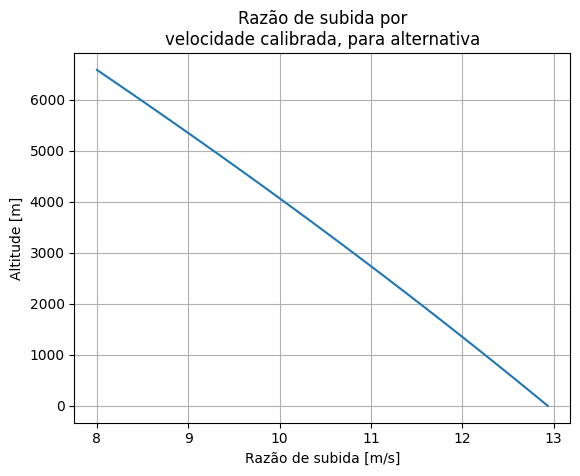

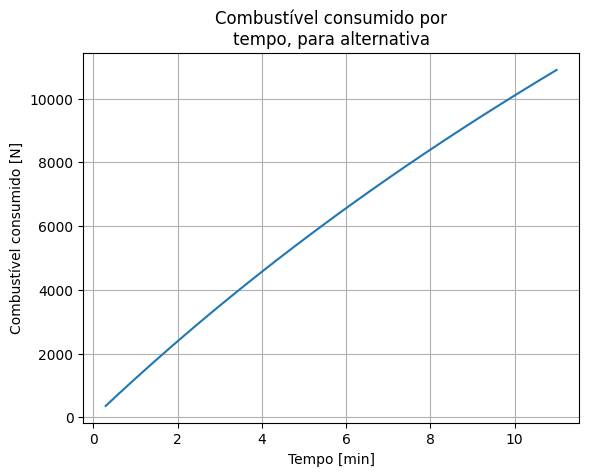

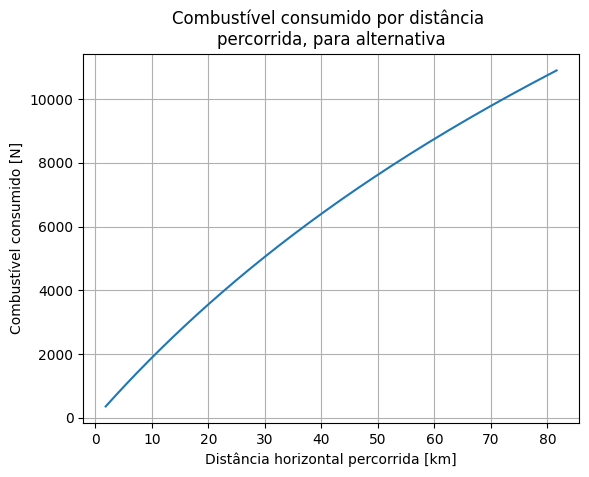

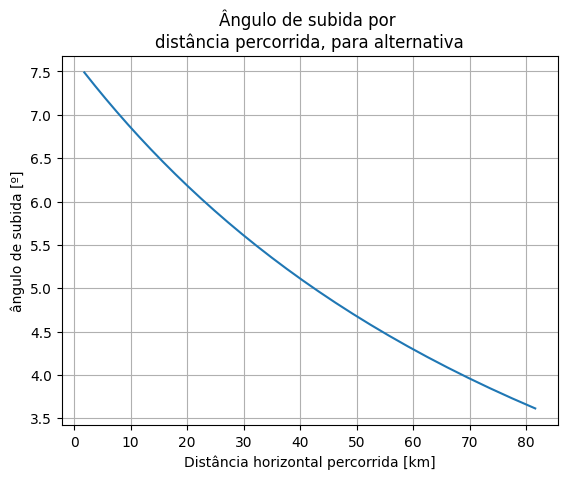

In [ ]:
show_results(RC_climb_ph1, h_climb_ph1, 'Razão de subida [m/s]', 'Altitude [m]', 'Razão de subida por\nvelocidade calibrada, para alternativa')
print('\n')
show_results(np.cumsum(time_climb_ph1)/60, np.cumsum(FS_climb_ph1), 'Tempo [min]', 'Combustível consumido [N]', 'Combustível consumido por\ntempo, para alternativa')
print('\n')
show_results(np.cumsum(DT_climb_ph1)/1000, np.cumsum(FS_climb_ph1), 'Distância horizontal percorrida [km]', 'Combustível consumido [N]', 'Combustível consumido por distância \npercorrida, para alternativa')
print('\n')
show_results(np.cumsum(DT_climb_ph1)/1000, gamma_climb_ph1, 'Distância horizontal percorrida [km]', 'ângulo de subida [º]', 'Ângulo de subida por \ndistância percorrida, para alternativa')

Nota-se que não foi necessário aplicar *step climb*, uma vez que a razão de subida não foi menor que 500 ft/min (2.54 m/s)

## Cálculo da descida

É dividida em três etapas
- Descida de 20000 ft até 10000 ft
- Espera por 30 minutos em condição máxima autonomia
- Descida de 10000 ft até 2000 ft, chegando ao aeroposto alternativo

Para ela, considera-se empuxo em regime de *flight iddle*, dado por
\begin{equation}
 Thrust_{iddle} = 0.05 \; Thrust_0
\end{equation}
Ou seja, o empuxo empregado é 5% do empuxo total da aeronave.

In [ ]:
h1 = 20000
h2 = 10000
T_flight_iddle = 0.05 * Thrust0
W = MTOW - dfuel_climb_phase1

v_descent_ph1, gamma_descent_ph1, RC_descent_ph1, time_descent_ph1, DT_descent_ph1, FS_descent_ph1, h_descent_ph1 = compute_climbing_vectors(
    h1, h2, h_disc_ph1, delta_isa_ph1, T_flight_iddle, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Armazena distância horizontal percorrida e combustível consumido para descida

dist_descent_phase1_ft10000 = np.cumsum(DT_descent_ph1)[-1]/1000
dfuel_descent_phase1_ft_10000 = np.cumsum(FS_descent_ph1)[-1]
t_descent_phase1_ft10000 = np.cumsum(time_descent_ph1)[-1]/60

## Visualização dos resultados na descida da etapa 1

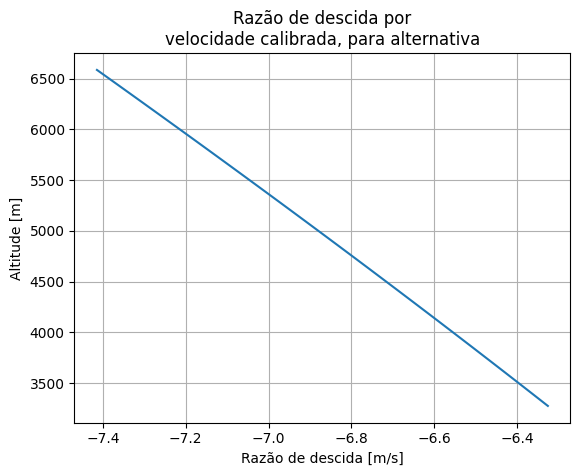

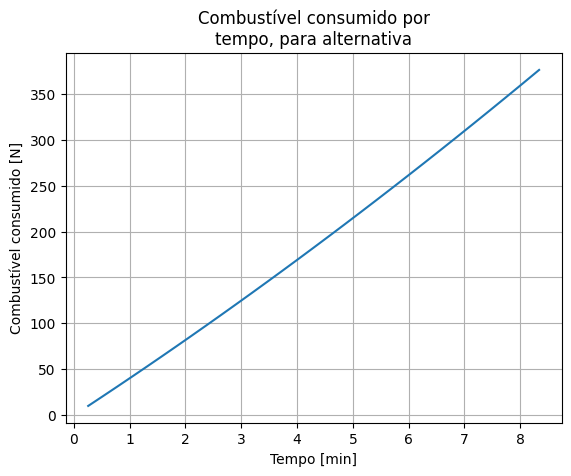

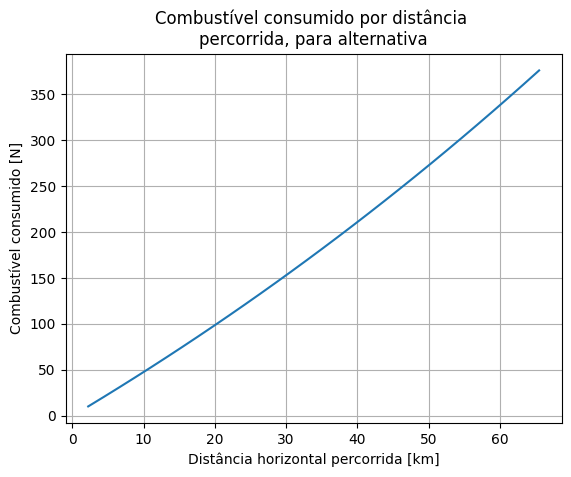

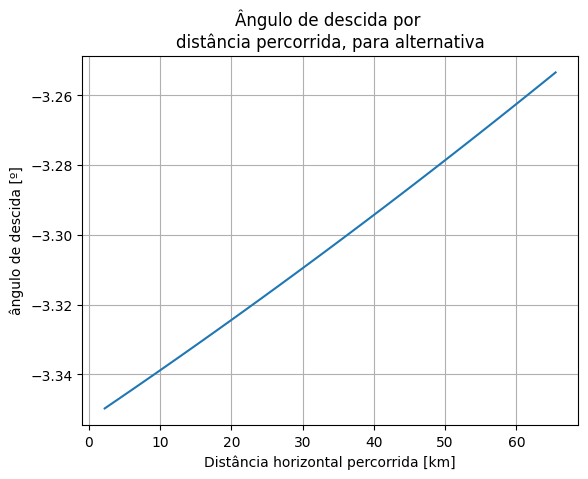

In [ ]:
show_results(RC_descent_ph1, h_descent_ph1, 'Razão de descida [m/s]', 'Altitude [m]', 'Razão de descida por\nvelocidade calibrada, para alternativa')
print('\n')
show_results(np.cumsum(time_descent_ph1)/60, np.cumsum(FS_descent_ph1), 'Tempo [min]', 'Combustível consumido [N]', 'Combustível consumido por\ntempo, para alternativa')
print('\n')
show_results(np.cumsum(DT_descent_ph1)/1000, np.cumsum(FS_descent_ph1), 'Distância horizontal percorrida [km]', 'Combustível consumido [N]', 'Combustível consumido por distância \npercorrida, para alternativa')
print('\n')
show_results(np.cumsum(DT_descent_ph1)/1000, gamma_descent_ph1, 'Distância horizontal percorrida [km]', 'ângulo de descida [º]', 'Ângulo de descida por \ndistância percorrida, para alternativa')


## Cálculo da espera para etapa 1

In [ ]:
_, _, rho, _ = atmosfera_real(ft2m(10000), delta_isa=20)
W = MTOW - dfuel_climb_phase1 - dfuel_descent_phase1_ft_10000

t_plot, fuel_spent_plot_standby = max_endurance_cruise(rho, S, CD0, K, W, TSFC, t_total=30*60)

# Armazenando combustível consumido e tempo na espera

dfuel_standby_phase1 = np.cumsum(fuel_spent_plot_standby)[-1]
t_standby_phase1 = t_plot[-1]

## Visualizando etapa de espera para alternativa

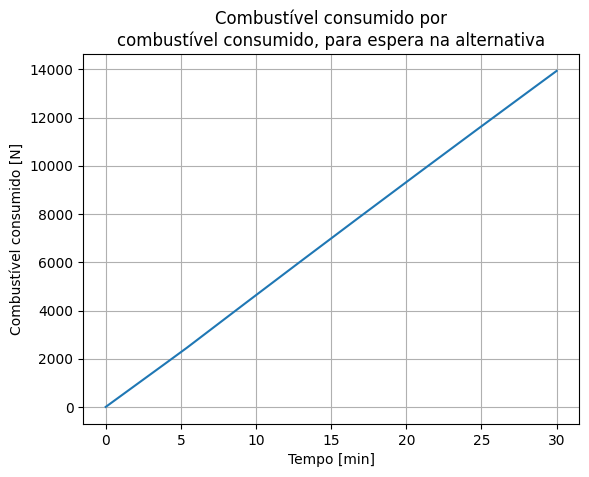

In [ ]:
show_results(t_plot, np.cumsum(fuel_spent_plot_standby), 'Tempo [min]', 'Combustível consumido [N]', 'Combustível consumido por\ncombustível consumido, para espera na alternativa')

## Segunda etapa de descida até pouso na alternativa

In [ ]:
h1 = 10000
h2 = 2000
W = MTOW - dfuel_descent_phase1_ft_10000 - dfuel_climb_phase1 - dfuel_standby_phase1

v_descent2_ph1, gamma_descent2_ph1, RC_descent2_ph1, time_descent2_ph1, DT_descent2_ph1, FS_descent2_ph1, h_descent2_ph1 = compute_climbing_vectors(
    h1, h2, h_disc_ph1, delta_isa_ph1, T_flight_iddle, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Armazena distância horizontal percorrida, combustível consumido e tempo despendido para descida

dist_descent_phase1_ft0 = np.cumsum(DT_descent2_ph1)[-1]/1000
dfuel_descent_phase1_ft_0 = np.cumsum(FS_descent2_ph1)[-1]
t_descent_phase1_ft0 = np.cumsum(time_descent2_ph1)[-1]/60

## Visualização da segunda etapa de pouso

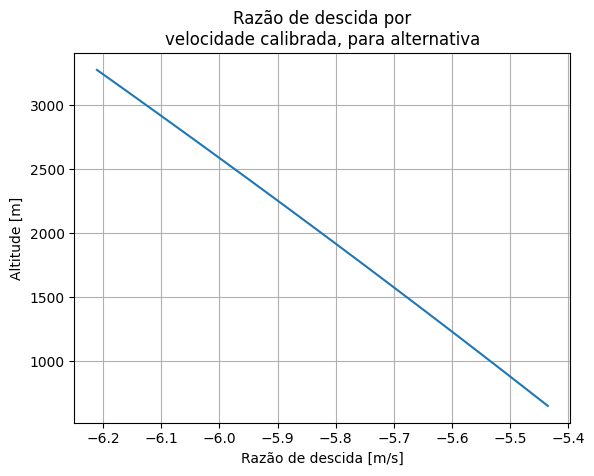

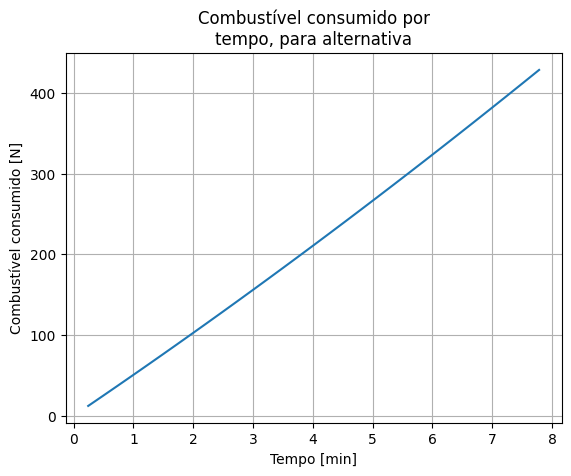

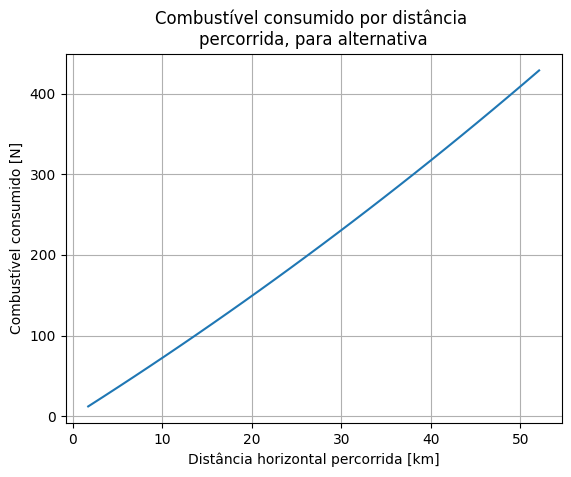

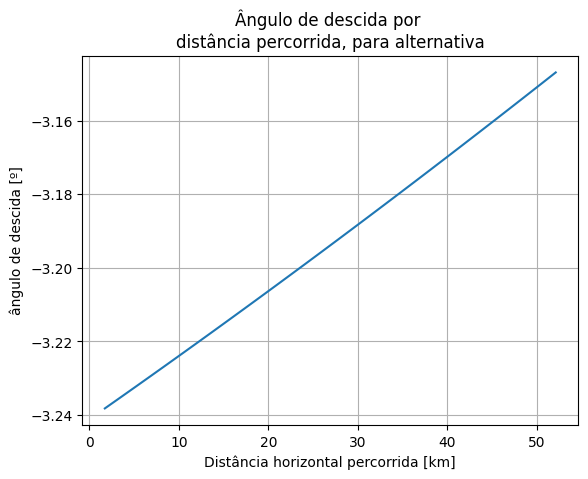

In [ ]:
show_results(RC_descent2_ph1, h_descent2_ph1, 'Razão de descida [m/s]', 'Altitude [m]', 'Razão de descida por\nvelocidade calibrada, para alternativa')
print('\n')
show_results(np.cumsum(time_descent2_ph1)/60, np.cumsum(FS_descent2_ph1), 'Tempo [min]', 'Combustível consumido [N]', 'Combustível consumido por\ntempo, para alternativa')
print('\n')
show_results(np.cumsum(DT_descent2_ph1)/1000, np.cumsum(FS_descent2_ph1), 'Distância horizontal percorrida [km]', 'Combustível consumido [N]', 'Combustível consumido por distância \npercorrida, para alternativa')
print('\n')
show_results(np.cumsum(DT_descent2_ph1)/1000, gamma_descent2_ph1, 'Distância horizontal percorrida [km]', 'ângulo de descida [º]', 'Ângulo de descida por \ndistância percorrida, para alternativa')

## Cálculo de cruzeiro para alternativa

In [ ]:
h = 20000
W = MTOW - dfuel_climb_phase1 - dfuel_descent_phase1_ft_10000 - dfuel_standby_phase1 - dfuel_descent_phase1_ft_0
delta_x_first_phase = nm2m(200) - dist_climb_phase1 - dist_descent_phase1_ft10000

t_plot_cruise_ph1, x_plot_cruise_ph1, fuel_spent_plot_cruise_ph1 = long_range_cruise_fixed_distance(
    h, delta_isa_ph1, S, K, CD0, TSFC, delta_x_first_phase, W, rho
    )

# Armazenando combustível consumido, distância percorrida e tempo despedido

dist_cruise_phase1 = x_plot_cruise_ph1[-1]
dfuel_cruise_phase1 = np.cumsum(fuel_spent_plot_cruise_ph1)[-1]
t_cruise_phase1 = t_plot_cruise_ph1[-1]

## Visualização do cruzeiro para alternativa

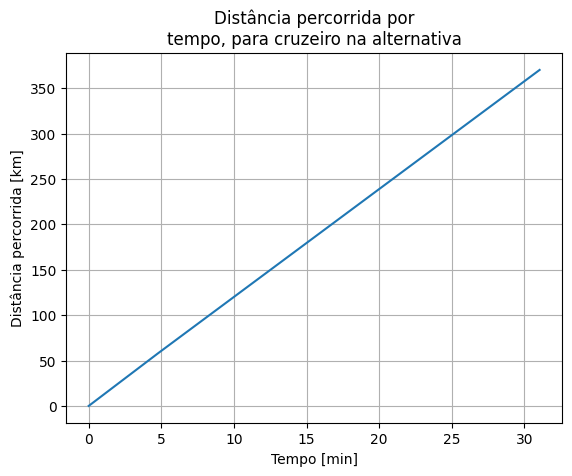

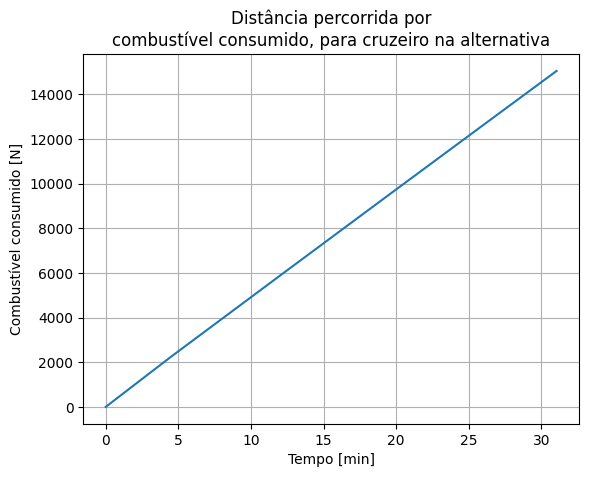

In [ ]:
show_results(t_plot_cruise_ph1, x_plot_cruise_ph1, 'Tempo [min]', 'Distância percorrida [km]', 'Distância percorrida por\ntempo, para cruzeiro na alternativa')
print('\n')
show_results(t_plot_cruise_ph1, np.cumsum(fuel_spent_plot_cruise_ph1), 'Tempo [min]', 'Combustível consumido [N]', 'Distância percorrida por\ncombustível consumido, para cruzeiro na alternativa')

# Etapa 2 - Aeroporto de saída até o destino

Parte-se novamente do MTOW, calculando, nesta ordem:
- Decréscimo de 100 Kg de combustível devido à decolagem, valor arbitrário de referência;
- Subida de 0 a 41000 ft;
- Descida de 41000 ft até 0 - preza-se pelo conservadorismo, extrapolando a rota como se a arremetida fosse feita ao nível do mar;
- Cruzeiro em 41000 ft, usando o combustível restante ao descontar o consumo dos três tópicos anteriores e todo o combustível consumido na etapa 1

## Subida para etapa 2

In [ ]:
h_disc_ph2 = 40
h1 = 0
h2 = 41000
delta_isa_ph2 = 15
W = MTOW - 100*g # Desconta-se 100 Kg de combustível para decolagem

v_climb_ph2, gamma_climb_ph2, RC_climb_ph2, time_climb_ph2, DT_climb_ph2, FS_climb_ph2, h_climb_ph2 = compute_climbing_vectors(
    h1, h2, h_disc_ph2, delta_isa_ph2, Thrust0, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Armazena distância horizontal percorrida e combustível consumido para subida

dist_climb_phase2 = np.cumsum(DT_climb_ph2)[-1]/1000
dfuel_climb_phase2 = np.cumsum(FS_climb_ph2)[-1]
t_climb_phase2 = np.cumsum(time_climb_ph2)[-1]/60

## Visualização da subida para rota principal

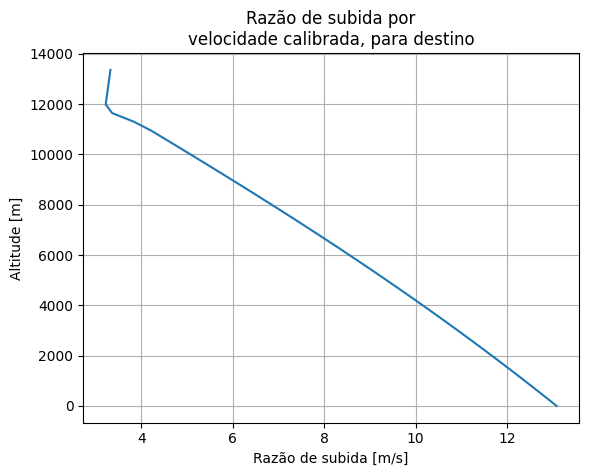

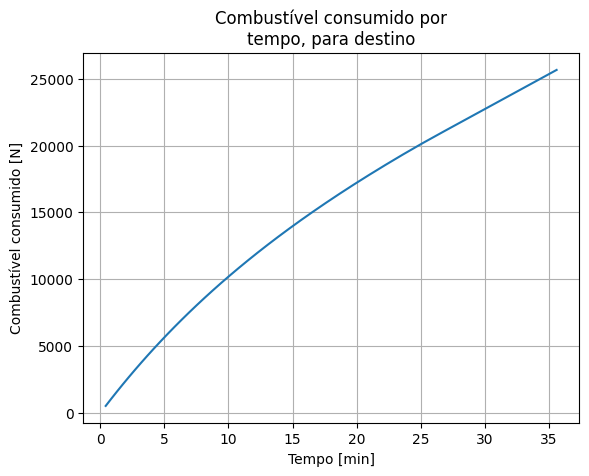

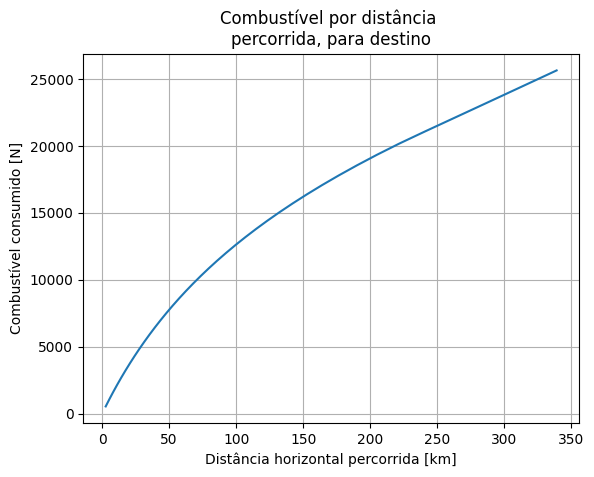

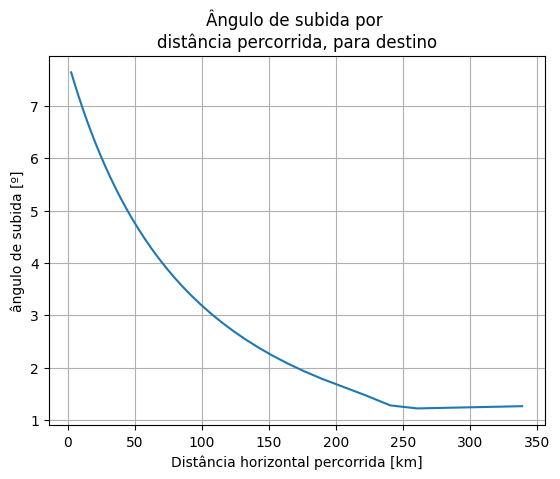

In [ ]:
show_results(RC_climb_ph2, h_climb_ph2, 'Razão de subida [m/s]', 'Altitude [m]', 'Razão de subida por\nvelocidade calibrada, para destino')
print('\n')
show_results(np.cumsum(time_climb_ph2)/60, np.cumsum(FS_climb_ph2), 'Tempo [min]', 'Combustível consumido [N]', 'Combustível consumido por\ntempo, para destino')
print('\n')
show_results(np.cumsum(DT_climb_ph2)/1000, np.cumsum(FS_climb_ph2), 'Distância horizontal percorrida [km]', 'Combustível consumido [N]', 'Combustível por distância \npercorrida, para destino')
print('\n')
show_results(np.cumsum(DT_climb_ph2)/1000, gamma_climb_ph2, 'Distância horizontal percorrida [km]', 'ângulo de subida [º]', 'Ângulo de subida por \ndistância percorrida, para destino')

Nota-se, novamente, que não foi necessário aplicar *step climb*, uma vez que a razão de subida não foi menor que 500 ft/min (2.54 m/s)

## Descida para etapa 2

In [ ]:
h1 = 41000
h2 = 0
W = MTOW - 100*g - dfuel_climb_phase2
T_flight_iddle = 0.05 * Thrust0

v_descent_ph2, gamma_descent_ph2, RC_descent_ph2, time_descent_ph2, DT_descent_ph2, FS_descent_ph2, h_descent_ph2 = compute_climbing_vectors(
    h1, h2, h_disc_ph2, delta_isa_ph2, T_flight_iddle, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Armazena distância horizontal percorrida e combustível consumido para descida

dist_descent_phase2 = np.cumsum(DT_descent_ph2)[-1]/1000
dfuel_descent_phase2 = np.cumsum(FS_descent_ph2)[-1]
t_descent_phase2 = np.cumsum(time_descent_ph2)[-1]/60

## Visualização da descida da etapa 2

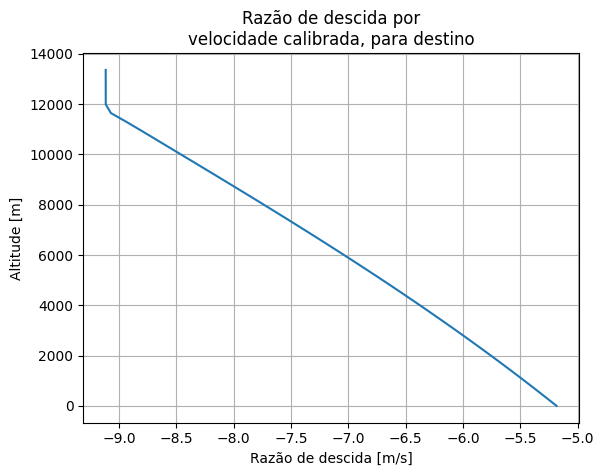

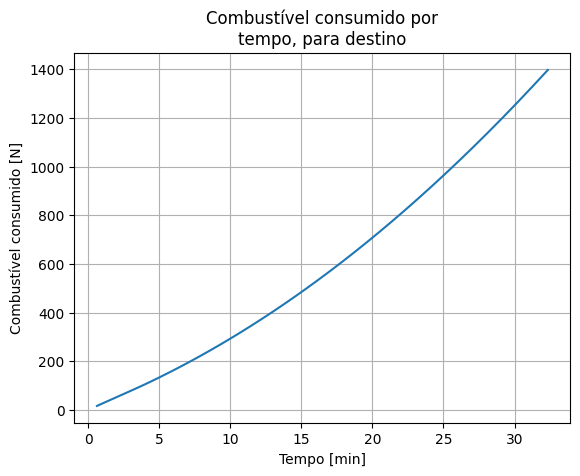

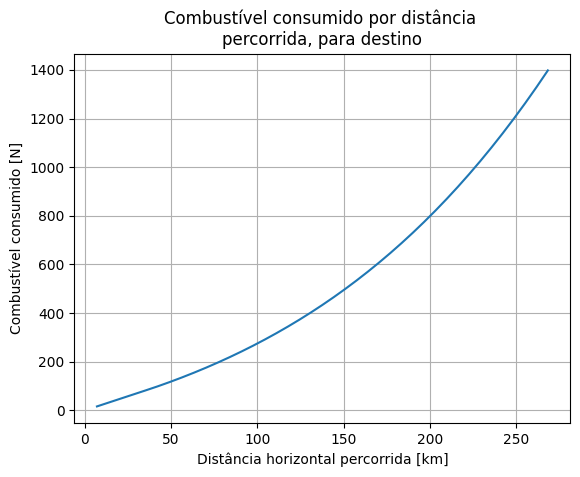

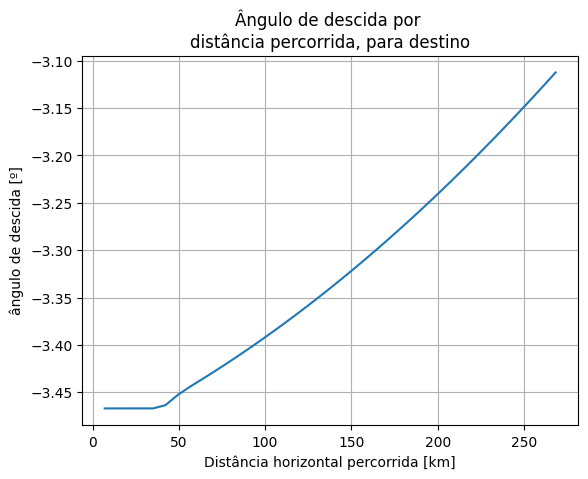

In [ ]:
show_results(RC_descent_ph2, h_descent_ph2, 'Razão de descida [m/s]', 'Altitude [m]', 'Razão de descida por\nvelocidade calibrada, para destino')
print('\n')
show_results(np.cumsum(time_descent_ph2)/60, np.cumsum(FS_descent_ph2), 'Tempo [min]', 'Combustível consumido [N]', 'Combustível consumido por\ntempo, para destino')
print('\n')
show_results(np.cumsum(DT_descent_ph2)/1000, np.cumsum(FS_descent_ph2), 'Distância horizontal percorrida [km]', 'Combustível consumido [N]', 'Combustível consumido por distância \npercorrida, para destino')
print('\n')
show_results(np.cumsum(DT_descent_ph2)/1000, gamma_descent_ph2, 'Distância horizontal percorrida [km]', 'ângulo de descida [º]', 'Ângulo de descida por \ndistância percorrida, para destino')


## Cruzeiro para etapa 2

A metodologia envolve subtrair todo o coonsumo estimado para todas as demais etapas, e impor um *leftover fuel* (combustível de sobra) de 10% do peso de combustível total, em prol do conservadorismo para realização da missão

In [ ]:
h = 41000
W = (MTOW - dfuel_climb_phase1 - dfuel_descent_phase1_ft_10000 - dfuel_standby_phase1
     - dfuel_descent_phase1_ft_0 - dfuel_cruise_phase1 - dfuel_climb_phase2 -
     dfuel_descent_phase2)

leftover_fuel = 0.1 # Porcentagem de combustível de sobra desejado

t_plot_cruise_ph2, x_plot_cruise_ph2, fuel_spent_plot_cruise_ph2 = long_range_cruise_fixed_W(
    h, delta_isa_ph2, S, K, CD0, TSFC, W, W_0fuel, leftover_fuel, Wf, rho
    )

# Armazenando combustível consumido

dist_cruise_phase2 = x_plot_cruise_ph2[-1]
dfuel_cruise_phase2 = np.cumsum(fuel_spent_plot_cruise_ph2)[-1]
t_cruise_phase2 = t_plot[-1]

## Visualização do cruzeiro para etapa 2

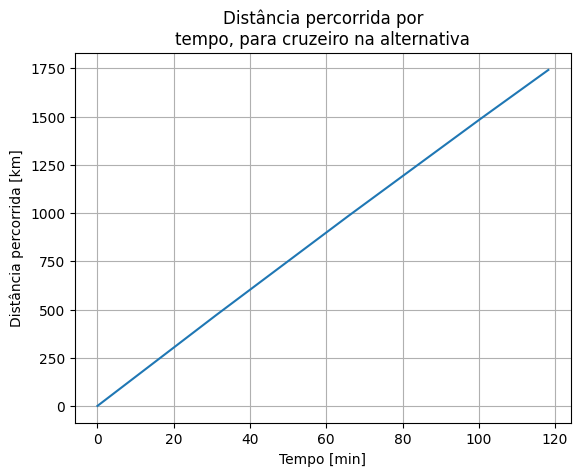

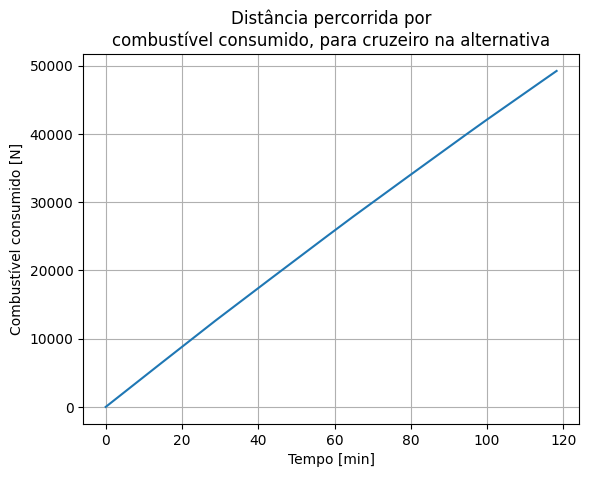

In [ ]:
show_results(t_plot_cruise_ph2, x_plot_cruise_ph2, 'Tempo [min]', 'Distância percorrida [km]', 'Distância percorrida por\ntempo, para cruzeiro na alternativa')
print('\n')
show_results(t_plot_cruise_ph2, np.cumsum(fuel_spent_plot_cruise_ph2), 'Tempo [min]', 'Combustível consumido [N]', 'Distância percorrida por\ncombustível consumido, para cruzeiro na alternativa')

# Resultados após estimativa das etapas 1 e 2

In [ ]:
dfuel_estimated = (dfuel_climb_phase2 + dfuel_cruise_phase2 + dfuel_descent_phase2 +
                   dfuel_climb_phase1 + dfuel_cruise_phase1 + dfuel_descent_phase1_ft_10000 +
                   dfuel_standby_phase1 + dfuel_descent_phase1_ft_0)

dist_estimated = (dist_climb_phase2 + dist_cruise_phase2 + dist_descent_phase2 +
                  dist_climb_phase1 + dist_cruise_phase1 + dist_descent_phase1_ft10000 +
                  dist_descent_phase1_ft0)

t_estimated = (t_climb_phase2 + t_cruise_phase2 + t_descent_phase2 +
               t_climb_phase1 + t_cruise_phase1 + t_descent_phase1_ft10000 +
               t_standby_phase1 + t_descent_phase1_ft0)

print(f'Combustível restante: {Wf-dfuel_estimated} [N]')
print(f'Distância percorrida total, somando alternativa: {dist_estimated} [km]')
print(f'Tempo total do percurso, incluindo espera na alternativa: {t_estimated} [min]')

Combustível restante: 12995.467434346108 [N]
Distância percorrida total, somando alternativa: 2919.3700007729803 [km]
Tempo total do percurso, incluindo espera na alternativa: 186.1048243675386 [min]


# Etapa 3 - recalculando e obtendo rota completa

Como já mencionado, as estratégias adotadas para estimar cada etapa acarretaram em estimativas cujo peso no início de determinada missão (vide, por exemplo, ter partido do MTOW no percurso de subida para etapa 1, quando, na realidade, a aeronave já tivesse gasto todo o combusível estimado na etapa 2).

Sendo assim, usando dos consumos de combustível estimados, objetiva-se acoplar todas as fases.

Vale destacar duas estratégias empregadas na solução: para o cáculo de cruzeiro, utiliza-se da previsão obtida de consumo de combustível nas etapas 1 e 2, a fim de obter qual o consumo esperado e, assim, projetar uma sobra de combustível ao final que seja semelhante à estimada anteriormente. A rotina abaixo ilustra este processo.

In [ ]:
# Partida até chegada

h_disc_ph2 = 40
h1 = 0
h2 = 41000
delta_isa_ph2 = 15

# Subida

W = MTOW - 100*g # Desconta-se 100 Kg de combustível para decolagem

_, _, _, time_climb_ph2, DT_climb_ph2, FS_climb_ph2, h_climb_ph2 = compute_climbing_vectors(
    h1, h2, h_disc_ph2, delta_isa_ph2, Thrust0, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Cruzeiro

h = 41000
h_real, _, _, _ = atmosfera_real(ft2m(h), delta_isa_ph2)
W -= np.cumsum(FS_climb_ph2)[-1]
dfuel_cruise_estimated = 52300 # [N]

leftover_fuel = (Wf - np.cumsum(FS_climb_ph2)[-1] - dfuel_cruise_estimated ) / Wf
# Porcentagem de combustível de sobra desejado

time_cruise_ph2, DT_cruise_ph2, FS_cruise_ph2 = long_range_cruise_fixed_W(
    h, delta_isa_ph2, S, K, CD0, TSFC, W, W_0fuel, leftover_fuel, Wf, rho
    )
h_cruise_ph2 = h_real * np.ones(len(time_cruise_ph2))

# Descida

h1 = 41000
h2 = 0
W -=  np.cumsum(fuel_spent_plot_cruise_ph2)[-1]
T_flight_iddle = 0.05 * Thrust0

_, _, _, time_descent_ph2, DT_descent_ph2, FS_descent_ph2, h_descent_ph2 = compute_climbing_vectors(
    h1, h2, h_disc_ph2, delta_isa_ph2, T_flight_iddle, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Subida em direção à alternativa

delta_isa_ph1 = 20
h_disc_ph1 = 30
h1 = 0
h2 = 20000

W -= np.cumsum(FS_descent_ph2)[-1]


_, _, _, time_climb_ph1, DT_climb_ph1, FS_climb_ph1, h_climb_ph1 = compute_climbing_vectors(
    h1, h2, h_disc_ph1, delta_isa_ph1, Thrust0, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Cruzeiro em direção à alternativa

h = 20000
h_real, _, _, _ = atmosfera_real(ft2m(h), delta_isa_ph1)
W -= np.cumsum(FS_climb_ph1)[-1]
dfuel_cruise_estimated = 7300 # [N]

leftover_fuel = 0.16
# Sobra de combustível a partir da estimativa de combustível consumido

time_cruise_ph1, DT_cruise_ph1, FS_cruise_ph1 = long_range_cruise_fixed_W(
    h, delta_isa_ph1, S, K, CD0, TSFC, W, W_0fuel, leftover_fuel, Wf, rho
    )
h_cruise_ph1 = h_real * np.ones(len(time_cruise_ph1))

# Descida até 1000 ft

h1 = 20000
h2 = 10000
W -= np.cumsum(fuel_spent_plot_cruise_ph1)[-1]

_, _, _, time_descent_ph1, DT_descent_ph1, FS_descent_ph1, h_descent_ph1 = compute_climbing_vectors(
    h1, h2, h_disc_ph1, delta_isa_ph1, T_flight_iddle, W, S, K, CD0, Emax, CL_Emax, TSFC
)

# Espera por 30 min

h = ft2m(10000)
_, _, rho, _ = atmosfera_real(ft2m(h), delta_isa_ph1)
W -= np.cumsum(FS_descent_ph1)[-1]

time_standby, FS_standby = max_endurance_cruise(rho, S, CD0, K, W, TSFC, t_total=30*60)
DT_standby = np.cumsum(DT_descent_ph1)[-1]/1000 * np.ones(len(time_standby))
h_standby = h * np.ones(len(time_standby))

# Descida até alternativa

h1 = 10000
h2 = 2000
W -= np.cumsum(fuel_spent_plot_standby)[-1]

_, _, _, time_descent2_ph1, DT_descent2_ph1, FS_descent2_ph1, h_descent2_ph1 = compute_climbing_vectors(
    h1, h2, h_disc_ph1, delta_isa_ph1, T_flight_iddle, W, S, K, CD0, Emax, CL_Emax, TSFC
)


## Para facilitar a visualização, une-se todos os vetores relacionados a:
- Distância hrizontal percorrida
- Tempo despendido
- Combustível consumido
- Altitudes da aeronave ao longo da missão

In [ ]:
distance = np.append(np.cumsum(DT_climb_ph2)/1000, np.cumsum(DT_climb_ph2)[-1]/1000 + DT_cruise_ph2)
distance = np.append(distance, distance[-1] + np.cumsum(DT_descent_ph2)/1000)
distance = np.append(distance, distance[-1] + np.cumsum(DT_climb_ph1)/1000)
distance = np.append(distance, distance[-1] + DT_cruise_ph1)
distance = np.append(distance, distance[-1] + np.cumsum(DT_descent_ph1)/1000)
distance = np.append(distance, distance[-1] + DT_standby)
distance = np.append(distance, distance[-1] + np.cumsum(DT_descent2_ph1)/1000)

time = np.append(np.cumsum(time_climb_ph2)/60, np.cumsum(time_climb_ph2)[-1]/60 + time_cruise_ph2)
time = np.append(time, time[-1] + np.cumsum(time_descent_ph2)/60)
time = np.append(time, time[-1] + np.cumsum(time_climb_ph1)/60)
time = np.append(time, time[-1] + time_cruise_ph1)
time = np.append(time, time[-1] + np.cumsum(time_descent_ph1)/60)
time = np.append(time, time[-1] + time_standby)
time = np.append(time, time[-1] + np.cumsum(time_descent2_ph1)/60)


dfuel = np.append(np.cumsum(FS_climb_ph2), np.cumsum(FS_climb_ph2)[-1] + np.cumsum(FS_cruise_ph2))
dfuel = np.append(dfuel, dfuel[-1] + np.cumsum(FS_descent_ph2))
dfuel = np.append(dfuel, dfuel[-1] + np.cumsum(FS_climb_ph1))
dfuel = np.append(dfuel, dfuel[-1] + np.cumsum(FS_cruise_ph1))
dfuel = np.append(dfuel, dfuel[-1] + np.cumsum(FS_descent_ph1))
dfuel = np.append(dfuel, dfuel[-1] + np.cumsum(FS_standby))
dfuel = np.append(dfuel, dfuel[-1] + np.cumsum(FS_descent2_ph1))

altitude = np.append(h_climb_ph2, h_cruise_ph2)
altitude = np.append(altitude, h_descent_ph2)
altitude = np.append(altitude, h_climb_ph1)
altitude = np.append(altitude, h_cruise_ph1)
altitude = np.append(altitude, h_descent_ph1)
altitude = np.append(altitude, h_standby)
altitude = np.append(altitude, h_descent2_ph1)

## Visualizando a trajetória total e consumo de combustível

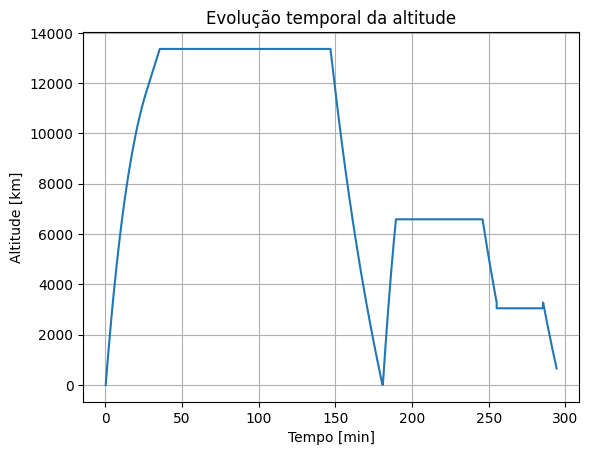

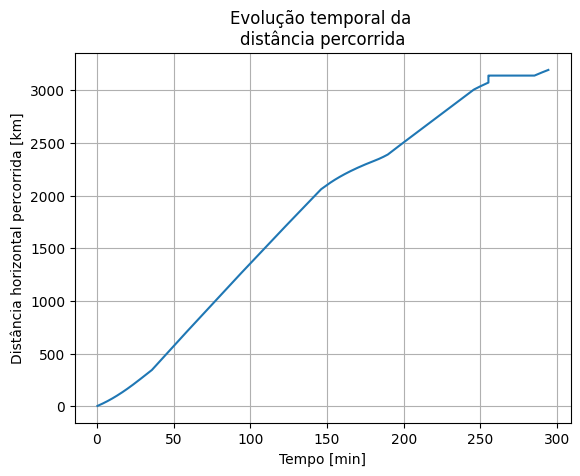

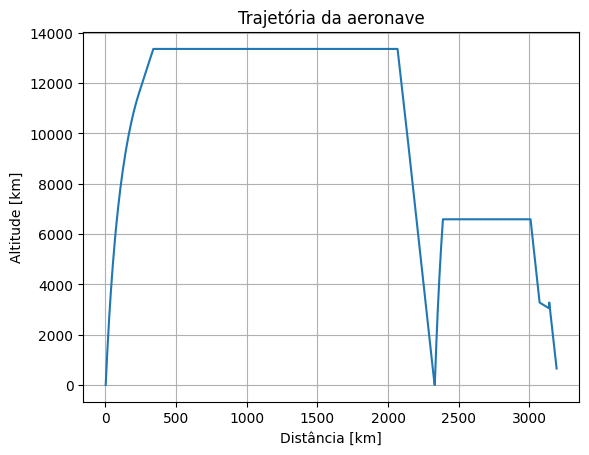

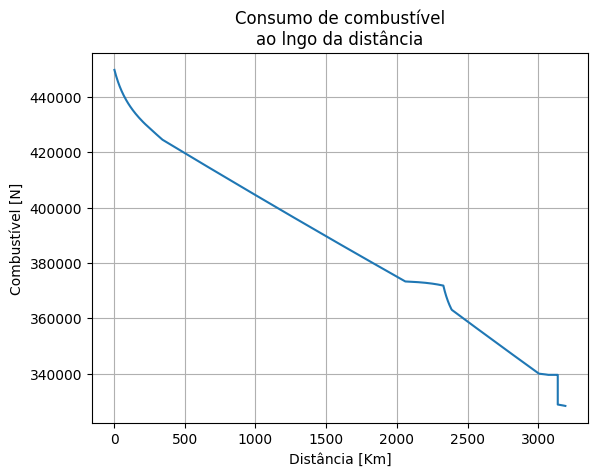

In [ ]:
show_results(time, altitude, 'Tempo [min]', 'Altitude [km]', 'Evolução temporal da altitude')
print('\n')
show_results(time, distance, 'Tempo [min]', 'Distância horizontal percorrida [km]', 'Evolução temporal da \ndistância percorrida')
print('\n')
show_results(distance, altitude, 'Distância [km]', 'Altitude [km]', 'Trajetória da aeronave')
print('\n')
show_results(distance, MTOW - dfuel, 'Distância [Km]', 'Combustível [N]', 'Consumo de combustível\nao lngo da distância')

Verifica-se, a partir dos resultados, em função da perda de peso acumulativa em relação à estimativa das etapas 1 e 2:
- O alcance aumentou em cerca de 200 km;
- O tempo de viagem aumentou em pouco menos de 2 horas, uma vez que, para a sustentação igualar a um peso menor, a velocidade ao longo do percurso, em especial o trajeto até a alternativa, foi menor;
- Ainda não foi necessário aplicar *step climb*;
- Para manter uma sobra de 8800 N (menor que a margem de 13000 N estimados), foi necessário adotar, de maneira iterativa, uma margem de combustível para cruzeiro até alternativa de 16%, maior que os 10% estimados

Pode-se comentar ainda que a aeronave em questão apresenta desempenho similar, em termos de autonomia, à aeronaves regionais. A nível de comparação, o Phenom 100 apresenta autonomia de 2100 km, ao passo que o Phenom 300 possui autonomia de 3600 km; portanto, a aeronave analisada encontra-se entre ambas, adotando uma margem de segurança de sobra de combustível de 8000 N; sem adotar esta margem, o alcance é similar ao Phenom 300.